Citation -- Used multiple resources to understand and compile code for MDP algorithm.

In [1]:
import gym
import time
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
from gym.envs.toy_text.frozen_lake import generate_random_map
from hiive.mdptoolbox.mdp import PolicyIteration, ValueIteration, QLearning, PolicyIterationModified
from hiive.mdptoolbox.example import forest
from timeit import default_timer as timer
from datetime import timedelta

import warnings
warnings.filterwarnings('ignore')

# Functions

In [2]:
def frozen_lake_environment(size=4,p=0.80):
    __size = size
    environment  = 'FrozenLake-v0'
    desc_map = generate_random_map(size=__size,p=p)
    env = gym.make(environment,desc=desc_map,is_slippery=True)
    env.reset()
    
#     env = gym.make(environment)
    states = env.observation_space.n
    actions = env.action_space.n
    env = env.unwrapped
    desc = env.unwrapped.desc
    return env, desc, states, actions, __size

In [3]:
def frozen_lake_get_PR(env,states,actions):
    prob_transitions = np.zeros((actions, states, states))
    rewards = np.zeros((states,actions))
    for state in env.P:
        for action in env.P[state]:
            for opt in env.P[state][action]:
                prob_transitions[action][state][opt[1]] += opt[0]
                rewards[state][action] += opt[2]
    return prob_transitions, rewards

In [4]:
def forest_get_PR(input_state):
    prob_transitions, rewards = forest(S=input_state)
    return prob_transitions, rewards

In [5]:
def gamma_analysis(gamma_prob_transitions,gamma_rewards,gamma_size,gamma_gammas=np.arange(0.1, 0.99, 0.01)):
    VI_ary, PI_ary = [],[]
#     gammas = np.arange(0.1, 0.99, 0.04)
    gammas = gamma_gammas
    for gamma in gammas:
        vi = ValueIteration(gamma_prob_transitions,gamma_rewards, gamma)
        vi.run()
        vi_time = vi.time
        vi_max_value = np.amax(vi.V)
        vi_mean_value = np.mean(vi.V)
        vi_value = vi.V
        vi_iters = vi.iter
        vi_policy = vi.policy
        VI_ary.append(['VI',gamma_size,gamma,vi_time,vi_max_value,vi_mean_value,vi_iters,vi_policy,vi_value])
        
        pi = PolicyIteration(gamma_prob_transitions,gamma_rewards, gamma)
        pi.run()
        pi_time = pi.time
        pi_max_value = np.amax(pi.V)
        pi_mean_value = np.mean(pi.V)
        pi_value = pi.V
        pi_iters = pi.iter
        pi_policy = pi.policy
        PI_ary.append(['PI',gamma_size,gamma,pi_time,pi_max_value,pi_mean_value,pi_iters,pi_policy,pi_value])
    
    df_vi = pd.DataFrame(VI_ary,columns=['iter_type','size','gamma','time','max_value','mean_value','iterations','policy','value'])
    df_pi = pd.DataFrame(PI_ary,columns=['iter_type','size','gamma','time','max_value','mean_value','iterations','policy','value'])
    return df_vi, df_pi

In [6]:
def plot_gamma_analysis(gamma_df_vi, gamma_df_pi):
    fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(20,4))
    sns.lineplot(gamma_df_vi['gamma'], gamma_df_vi['iterations'], linestyle='-.', label = "Value Iteration", ax=axs[0], alpha=0.5, color='red')
    sns.lineplot(gamma_df_pi['gamma'], gamma_df_pi['iterations'], linestyle='--', label = "Policy Iteration", ax=axs[0], alpha=0.5, color='blue')
    axs[0].set_title('Iterations vs Gamma')
    
    sns.lineplot(gamma_df_vi['gamma'], gamma_df_vi['time'], linestyle='-.', label = "Value Iteration", ax=axs[1], alpha=0.5, color='red')
    sns.lineplot(gamma_df_pi['gamma'], gamma_df_pi['time'], linestyle='--', label = "Policy Iteration", ax=axs[1], alpha=0.5, color='blue')
    axs[1].set_title('Time vs Gamma')

    sns.lineplot(gamma_df_vi['gamma'], gamma_df_vi['max_value'], linestyle='-.', label = "Value Iteration", ax=axs[2], alpha=0.5, color='red')
    sns.lineplot(gamma_df_pi['gamma'], gamma_df_pi['max_value'], linestyle='--', label = "Policy Iteration", ax=axs[2], alpha=0.5, color='blue')
    axs[2].set_title('Max Value vs Gamma')
    
    sns.lineplot(gamma_df_vi['gamma'], gamma_df_vi['mean_value'], linestyle='-.', label = "Value Iteration", ax=axs[3], alpha=0.5, color='red')
    sns.lineplot(gamma_df_pi['gamma'], gamma_df_pi['mean_value'], linestyle='--', label = "Policy Iteration", ax=axs[3], alpha=0.5, color='blue')
    axs[3].set_title('Mean Value vs Gamma')
    
    
    for ax in axs.flat:
        ax.legend(loc='best')
        ax.minorticks_on()
        ax.grid(b=True, which='major', color='k', linestyle='-', alpha=0.1)
        ax.grid(b=True, which='minor', color='r', linestyle='-', alpha=0.05)
    fig.tight_layout()

In [7]:
def epsilon_analysis(epsilon_prob_transitions,epsilon_rewards,epsilon_size,epsilon_epsilons=np.arange(0.001,0.05, 0.001),epsilon_gamma=0.99):
    VI_ary, PI_ary = [],[]
    gamma = epsilon_gamma
#     epsilons = np.arange(0.001,0.05, 0.005)
    epsilons = epsilon_epsilons
    
    for epsilon in epsilons:
        vi = ValueIteration(epsilon_prob_transitions,epsilon_rewards, gamma, epsilon=epsilon)
        vi.run()
        vi_time = vi.time
        vi_max_value = np.amax(vi.V)
        vi_mean_value = np.mean(vi.V)
        vi_value = vi.V
        vi_iters = vi.iter
        vi_policy = vi.policy
        VI_ary.append(['VI',epsilon_size,epsilon,vi_time,vi_max_value,vi_mean_value,vi_iters,vi_policy,vi_value])
        
        pi = PolicyIterationModified(epsilon_prob_transitions,epsilon_rewards, gamma, epsilon=epsilon)
        pi.run()
        pi_time = pi.time
        pi_max_value = np.amax(pi.V)
        pi_mean_value = np.mean(pi.V)
        pi_value = pi.V
        pi_iters = pi.iter
        pi_policy = pi.policy
        PI_ary.append(['PI',epsilon_size,epsilon,pi_time,pi_max_value,pi_mean_value,pi_iters,pi_policy,pi_value])
    
    df_vi = pd.DataFrame(VI_ary,columns=['iter_type','size','epsilon','time','max_value','mean_value','iterations','policy','value'])
    df_pi = pd.DataFrame(PI_ary,columns=['iter_type','size','epsilon','time','max_value','mean_value','iterations','policy','value'])
    return df_vi, df_pi

In [8]:
def plot_epsilon_analysis(epsilon_df_vi, epsilon_df_pi):
    fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(20,4))
    sns.lineplot(epsilon_df_vi['epsilon'], epsilon_df_vi['iterations'], linestyle='-.', label = "Value Iteration", ax=axs[0], alpha=0.5, color='red')
    sns.lineplot(epsilon_df_pi['epsilon'], epsilon_df_pi['iterations'], linestyle='--', label = "Policy Iteration", ax=axs[0], alpha=0.5, color='blue')
    axs[0].set_title('Iterations vs Epsilon')
    
    sns.lineplot(epsilon_df_vi['epsilon'], epsilon_df_vi['time'], linestyle='-.', label = "Value Iteration", ax=axs[1], alpha=0.5, color='red')
    sns.lineplot(epsilon_df_pi['epsilon'], epsilon_df_pi['time'], linestyle='--', label = "Policy Iteration", ax=axs[1], alpha=0.5, color='blue')
    axs[1].set_title('Time vs Epsilon')

    sns.lineplot(epsilon_df_vi['epsilon'], epsilon_df_vi['max_value'], linestyle='-.', label = "Value Iteration", ax=axs[2], alpha=0.5, color='red')
    sns.lineplot(epsilon_df_pi['epsilon'], epsilon_df_pi['max_value'], linestyle='--', label = "Policy Iteration", ax=axs[2], alpha=0.5, color='blue')
    axs[2].set_title('Max Value vs Epsilon')
    
    sns.lineplot(epsilon_df_vi['epsilon'], epsilon_df_vi['mean_value'], linestyle='-.', label = "Value Iteration", ax=axs[3], alpha=0.5, color='red')
    sns.lineplot(epsilon_df_pi['epsilon'], epsilon_df_pi['mean_value'], linestyle='--', label = "Policy Iteration", ax=axs[3], alpha=0.5, color='blue')
    axs[3].set_title('Mean Value vs Epsilon')
    
    
    for ax in axs.flat:
        ax.legend(loc='best')
        ax.minorticks_on()
        ax.grid(b=True, which='major', color='k', linestyle='-', alpha=0.1)
        ax.grid(b=True, which='minor', color='r', linestyle='-', alpha=0.05)
    fig.tight_layout()

In [9]:
def optimal_policy(optimal_df_vi,optimal_df_pi,optimal_size,epsilon,env_type):
    optimal_vi = optimal_df_vi[optimal_df_vi['epsilon'] == epsilon]
    optimal_pi = optimal_df_pi[optimal_df_pi['epsilon'] == epsilon]
    
    print(optimal_vi.shape)
    print(optimal_pi.shape)
    print(np.array(list(optimal_vi['policy'])).shape)
    print(np.array(list(optimal_pi['policy'])).shape)
    
    if env_type == 'frozen-lake':
        vi_policy_arr = np.array(list(optimal_vi['policy'])).reshape(optimal_size,optimal_size).astype(str)
        vi_value_arr = np.round(np.array(list(optimal_vi['value'])).reshape(optimal_size,optimal_size),2)
        
        
        vi_policy_arr[vi_policy_arr=='0'] = '←'
        vi_policy_arr[vi_policy_arr=='1'] = '↓'
        vi_policy_arr[vi_policy_arr=='2'] = '→'
        vi_policy_arr[vi_policy_arr=='3'] = '↑'
        
        vi_policy_viz = (np.asarray([a+" "+str(v) for a, v in zip(vi_policy_arr.flatten(), vi_value_arr.flatten())])).reshape(optimal_size,optimal_size)
        
    elif env_type == 'forest':
        
        vi_policy_arr = np.array(list(optimal_vi['policy'])).reshape(optimal_size).astype(str)
        vi_value_arr = np.round(np.array(list(optimal_vi['value'])).reshape(optimal_size),2)
        
        vi_policy_arr[vi_policy_arr=='0'] = 'W'
        vi_policy_arr[vi_policy_arr=='1'] = 'C'
        
        vi_policy_viz = (np.asarray([a+" "+str(v) for a, v in zip(vi_policy_arr.flatten(), vi_value_arr.flatten())])).reshape(optimal_size)
    
   
    if env_type == 'frozen-lake':
        pi_policy_arr = np.array(list(optimal_pi['policy'])).reshape(optimal_size,optimal_size).astype(str)
        pi_value_arr = np.round(np.array(list(optimal_pi['value'])).reshape(optimal_size,optimal_size),2)
    
        pi_policy_arr[pi_policy_arr=='0'] = '←'
        pi_policy_arr[pi_policy_arr=='1'] = '↓'
        pi_policy_arr[pi_policy_arr=='2'] = '→'
        pi_policy_arr[pi_policy_arr=='3'] = '↑'
        
        pi_policy_viz = (np.asarray([a+" "+str(v) for a, v in zip(pi_policy_arr.flatten(), pi_value_arr.flatten())])).reshape(optimal_size,optimal_size)
    elif env_type == 'forest':
        
        pi_policy_arr = np.array(list(optimal_pi['policy'])).reshape(optimal_size).astype(str)
        pi_value_arr = np.round(np.array(list(optimal_pi['value'])).reshape(optimal_size),2)
        
        pi_policy_arr[pi_policy_arr=='0'] = 'W'
        pi_policy_arr[pi_policy_arr=='1'] = 'C'
        
        pi_policy_viz = (np.asarray([a+" "+str(v) for a, v in zip(pi_policy_arr.flatten(), pi_value_arr.flatten())])).reshape(optimal_size)
    
    
    
    return vi_value_arr, vi_policy_viz, pi_value_arr, pi_policy_viz

In [10]:
def plot_optimnal_policy(plot_vi_value_arr, plot_vi_policy_viz, plot_pi_value_arr, plot_pi_policy_viz,plot_size,env_type):
    
    if env_type == 'frozen-lake':
        plt.figure(figsize=(plot_size,plot_size))
        plt.title("Value Iteration: Optimal Policy")
        sns.heatmap(plot_vi_value_arr, annot=plot_vi_policy_viz, fmt="")

        plt.figure(figsize=(plot_size,plot_size))
        plt.title("Policy Iteration: Optimal Policy")
        sns.heatmap(plot_pi_value_arr, annot=plot_pi_policy_viz, fmt="")
    elif env_type == 'forest':
        print("Value Iteration: Optimal Policy")
        line=""
        for val in plot_vi_policy_viz:
            line += (" {} |".format(val))
        print(line)
        
        print("Value Iteration: Optimal Policy")
        line=""
        for val in plot_pi_policy_viz:
            line += (" {} |".format(val))
        print(line)

In [11]:
def size_analysis(size_env_type,size_sizes,size_gamma=0.99):

#     fl_size = 8
# fl_p = 0.85
# env, desc, states, actions, size = frozen_lake_environment(fl_size,fl_p)

# fl_prob_transitions, fl_rewards = frozen_lake_get_PR(env,states,actions)

# fm_size = 1000
# fm_prob_transitions, fm_rewards = forest_get_PR(fm_size)

    sizes = size_sizes
    gamma = size_gamma
    VI_ary, PI_ary = [],[]

    for size in sizes:
        if size_env_type == 'frozen-lake':
            fl_p = 0.85
            env, desc, states, actions, _ = frozen_lake_environment(size,fl_p)
            size_prob_transitions, size_rewards = frozen_lake_get_PR(env,states,actions)
        elif size_env_type == 'forest':
            size_prob_transitions, size_rewards = forest_get_PR(size)
            
        vi = ValueIteration(size_prob_transitions, size_rewards, gamma)
        vi.run()
        vi_time = vi.time
        vi_max_value = np.amax(vi.V)
        vi_mean_value = np.mean(vi.V)
        vi_value = vi.V
        vi_iters = vi.iter
        vi_policy = vi.policy
        VI_ary.append(['VI',size,vi_time,vi_max_value,vi_mean_value,vi_iters,vi_policy,vi_value])
        
        pi = PolicyIterationModified(size_prob_transitions, size_rewards, gamma)
        pi.run()
        pi_time = pi.time
        pi_max_value = np.amax(pi.V)
        pi_mean_value = np.mean(pi.V)
        pi_value = pi.V
        pi_iters = pi.iter
        pi_policy = pi.policy
        PI_ary.append(['PI',size,pi_time,pi_max_value,pi_mean_value,pi_iters,pi_policy,pi_value])

        
    df_vi = pd.DataFrame(VI_ary,columns=['iter_type','size','time','max_value','mean_value','iterations','policy','value'])
    df_pi = pd.DataFrame(PI_ary,columns=['iter_type','size','time','max_value','mean_value','iterations','policy','value'])
    return df_vi, df_pi

In [12]:
def plot_size_analysis(size_df_vi, size_df_pi):
    fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(20,4))
    sns.lineplot(size_df_vi['size'], size_df_vi['iterations'], linestyle='-.', label = "Value Iteration", ax=axs[0], alpha=0.5, color='red')
    sns.lineplot(size_df_pi['size'], size_df_pi['iterations'], linestyle='--', label = "Policy Iteration", ax=axs[0], alpha=0.5, color='blue')
    axs[0].set_title('Iterations vs size')
    
    sns.lineplot(size_df_vi['size'], size_df_vi['time'], linestyle='-.', label = "Value Iteration", ax=axs[1], alpha=0.5, color='red')
    sns.lineplot(size_df_pi['size'], size_df_pi['time'], linestyle='--', label = "Policy Iteration", ax=axs[1], alpha=0.5, color='blue')
    axs[1].set_title('Time vs size')

    sns.lineplot(size_df_vi['size'], size_df_vi['max_value'], linestyle='-.', label = "Value Iteration", ax=axs[2], alpha=0.5, color='red')
    sns.lineplot(size_df_pi['size'], size_df_pi['max_value'], linestyle='--', label = "Policy Iteration", ax=axs[2], alpha=0.5, color='blue')
    axs[2].set_title('Max Value vs size')
    
    sns.lineplot(size_df_vi['size'], size_df_vi['mean_value'], linestyle='-.', label = "Value Iteration", ax=axs[3], alpha=0.5, color='red')
    sns.lineplot(size_df_pi['size'], size_df_pi['mean_value'], linestyle='--', label = "Policy Iteration", ax=axs[3], alpha=0.5, color='blue')
    axs[3].set_title('Mean Value vs size')
    
    
    for ax in axs.flat:
        ax.legend(loc='best')
        ax.minorticks_on()
        ax.grid(b=True, which='major', color='k', linestyle='-', alpha=0.1)
        ax.grid(b=True, which='minor', color='r', linestyle='-', alpha=0.05)
    fig.tight_layout()

In [13]:
def ql_gamma_analysis(ql_gamma_prob_transitions,ql_gamma_rewards,ql_gamma_size,ql_gamma_gammas=np.arange(0.1, 0.99, 0.01),ql_gamma_n_iter=100000):
    
    gammas = ql_gamma_gammas
    Q_ary = []
    
    for gamma in gammas:
        ql = QLearning(ql_gamma_prob_transitions,ql_gamma_rewards, gamma,n_iter=ql_gamma_n_iter)
        ql.run()
        ql_time = ql.time
        ql_max_value = np.amax(ql.V)
        ql_mean_value = np.mean(ql.V)
        ql_value = ql.V
        ql_q_matrix = ql.Q
        ql_policy = ql.policy
#         ql_mean_discrepancy = ql.mean_discrepancy
#         Q_ary.append(['QL',gamma_size,gamma,ql_time,ql_max_value,ql_mean_value,ql_q_matrix,ql_policy,ql_value,ql_mean_discrepancy])
        Q_ary.append(['QL',ql_gamma_size,gamma,ql_time,ql_max_value,ql_mean_value,ql_q_matrix,ql_policy,ql_value])

#     df_ql = pd.DataFrame(VI_ary,columns=['iter_type','size','gamma','time','max_value','mean_value','q_matrix','policy','value','mean_discrepancy'])
    df_gamma_ql = pd.DataFrame(Q_ary,columns=['iter_type','size','gamma','time','max_value','mean_value','q_matrix','policy','value'])
    return df_gamma_ql

In [14]:
def plot_ql_gamma_analysis(plot_gamma_df_ql):
    
    fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(20,4))
    
    
#     sns.lineplot(plot_gamma_df_ql['gamma'], plot_gamma_df_ql['iterations'], linestyle='-.', label = "Value Iteration", ax=axs[0], alpha=0.5, color='red')
#     axs[0].set_title('Iterations vs Gamma')
    
    sns.lineplot(plot_gamma_df_ql['gamma'], plot_gamma_df_ql['time'], linestyle='-.', label = "Q Learning", ax=axs[0], alpha=0.5, color='red')
    axs[0].set_title('Time vs Gamma')

    sns.lineplot(plot_gamma_df_ql['gamma'], plot_gamma_df_ql['max_value'], linestyle='-.', label = "Q Learning", ax=axs[1], alpha=0.5, color='red')
    axs[1].set_title('Max Value vs Gamma')
    
    sns.lineplot(plot_gamma_df_ql['gamma'], plot_gamma_df_ql['mean_value'], linestyle='-.', label = "Q Learning", ax=axs[2], alpha=0.5, color='red')
    axs[2].set_title('Mean Value vs Gamma')
    
    
    for ax in axs.flat:
        ax.legend(loc='best')
        ax.minorticks_on()
        ax.grid(b=True, which='major', color='k', linestyle='-', alpha=0.1)
        ax.grid(b=True, which='minor', color='r', linestyle='-', alpha=0.05)
    fig.tight_layout()

In [15]:
def ql_n_iter_analysis(ql_n_iter_prob_transitions,ql_n_iter_rewards,ql_n_iter_size,ql_n_iter_gamma=0.99,ql_n_iter_epsilon=0.9,ql_n_iter_n_iters=[10000,50000,100000]):
    
    n_iters = ql_n_iter_n_iters
    Q_ary = []
    run_stats = []
    
    for n_iter in n_iters:
#         ql = QLearning(ql_n_iter_prob_transitions,ql_n_iter_rewards, ql_n_iter_gamma,epsilon=ql_n_iter_epsilon,n_iter=n_iter)
        ql = QLearning(ql_n_iter_prob_transitions,ql_n_iter_rewards, ql_n_iter_gamma,epsilon=ql_n_iter_epsilon)
        ql.max_iter = n_iter
        ql_run_stat = ql.run()
        run_stats.extend(ql_run_stat)
#         print(run_stats)
        ql_time = ql.time
        ql_max_value = np.amax(ql.V)
        ql_mean_value = np.mean(ql.V)
        ql_value = ql.V
        ql_q_matrix = ql.Q
        ql_policy = ql.policy
#         ql_mean_discrepancy = ql.mean_discrepancy
#         Q_ary.append(['QL',gamma_size,gamma,ql_time,ql_max_value,ql_mean_value,ql_q_matrix,ql_policy,ql_value,ql_mean_discrepancy])
        Q_ary.append(['QL',ql_n_iter_size,n_iter,ql_time,ql_max_value,ql_mean_value,ql_q_matrix,ql_policy,ql_value])

#     df_ql = pd.DataFrame(VI_ary,columns=['iter_type','size','gamma','time','max_value','mean_value','q_matrix','policy','value','mean_discrepancy'])
    df_n_iter_ql = pd.DataFrame(Q_ary,columns=['iter_type','size','iterations','time','max_value','mean_value','q_matrix','policy','value'])
    df_n_iter_run_stat = pd.DataFrame.from_dict(ql_run_stat,orient='columns')
    return df_n_iter_ql, df_n_iter_run_stat

In [16]:
def plot_ql_n_iter_analysis(plot_n_iter_df_ql,plot_df_n_iter_run_stat):
    
    fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(20,5))
    
    
#     sns.lineplot(plot_n_iter_df_ql['gamma'], plot_n_iter_df_ql['iterations'], linestyle='-.', label = "Value Iteration", ax=axs[0], alpha=0.5, color='red')
#     axs[0].set_title('Iterations vs Gamma')
    
    sns.lineplot(plot_n_iter_df_ql['iterations'], plot_n_iter_df_ql['time'], linestyle='-.', label = "Q Learning", ax=axs[0], alpha=0.5, color='red')
    axs[0].set_title('Time vs Iterations')

    sns.lineplot(plot_n_iter_df_ql['iterations'], plot_n_iter_df_ql['max_value'], linestyle='-.', label = "Q Learning", ax=axs[1], alpha=0.5, color='red')
    axs[1].set_title('Max Value vs Iterations')
    
    sns.lineplot(plot_n_iter_df_ql['iterations'], plot_n_iter_df_ql['mean_value'], linestyle='-.', label = "Q Learning", ax=axs[2], alpha=0.5, color='red')
    axs[2].set_title('Mean Value vs Iterations')
    
#     sns.lineplot(plot_df_n_iter_run_stat['Iteration'], plot_df_n_iter_run_stat['Mean V'], linestyle='-.', label = "Q Learning", ax=axs[3], alpha=0.5, color='red')
#     axs[3].set_title('Mean Value vs Iterations')
    
    
    for ax in axs.flat:
        ax.legend(loc='best')
        ax.minorticks_on()
        ax.grid(b=True, which='major', color='k', linestyle='-', alpha=0.1)
        ax.grid(b=True, which='minor', color='r', linestyle='-', alpha=0.05)
    fig.tight_layout()

# Set Environments

## Frozen Lake

In [21]:
fl_size = 8
fl_p = 0.95
fl_env, fl_desc, fl_states, fl_actions, fl_size = frozen_lake_environment(fl_size,fl_p)

In [22]:
fl_prob_transitions, fl_rewards = frozen_lake_get_PR(fl_env,fl_states,fl_actions)

## Forest Management

In [23]:
fm_size = 1000
fm_prob_transitions, fm_rewards = forest_get_PR(fm_size)

In [24]:
fm_states = fm_size
fm_actions = 2

# Value Iteration and Policy Iteration

## Gamma Analysis

In [25]:
fl_gammas = np.arange(0.1, 0.99, 0.04)
fl_df_gamma_vi, fl_df_gamma_pi = gamma_analysis(fl_prob_transitions, fl_rewards,fl_size,fl_gammas)

In [26]:
fm_gammas = np.arange(0.1, 0.99, 0.04)
fm_df_gamma_vi, fm_df_gamma_pi= gamma_analysis(fm_prob_transitions, fm_rewards,fm_size,fm_gammas)

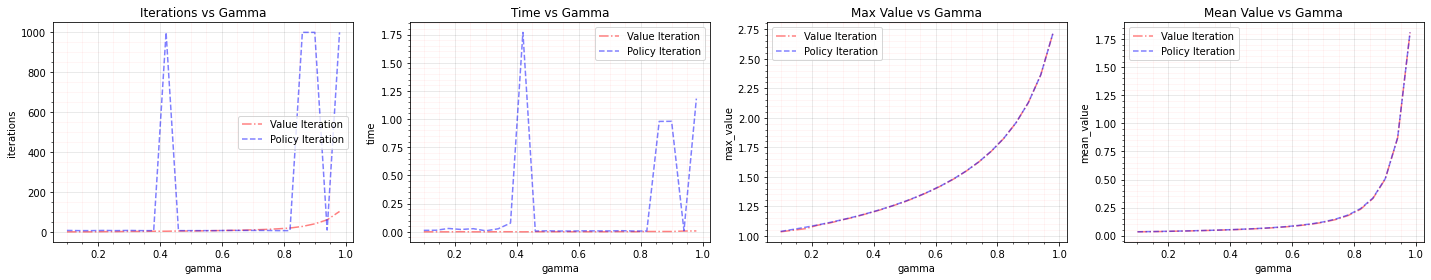

In [27]:
plot_gamma_analysis(fl_df_gamma_vi, fl_df_gamma_pi)

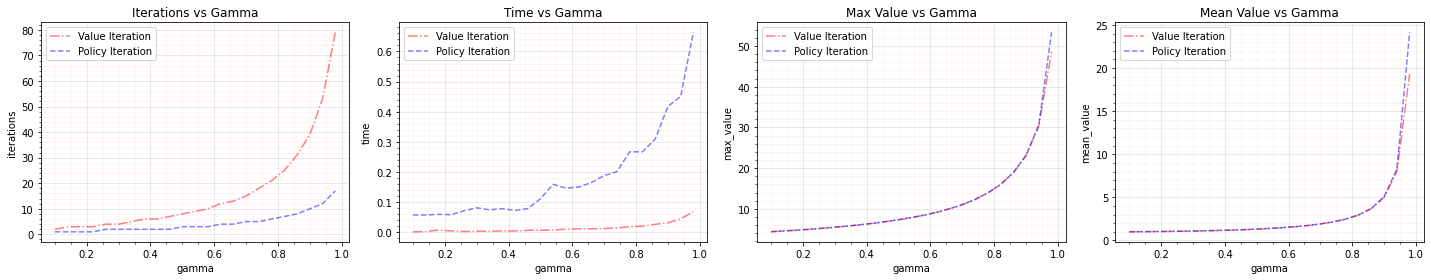

In [28]:
plot_gamma_analysis(fm_df_gamma_vi, fm_df_gamma_pi)

## Epsilon Analysis

In [29]:
fl_epsilons = np.arange(0.001,0.05, 0.001)
fl_gamma = 0.99
fl_df_epsilon_vi, fl_df_epsilon_pi = epsilon_analysis(fl_prob_transitions, fl_rewards,fl_size,fl_epsilons,fl_gamma)

In [30]:
# fm_epsilons = np.arange(0.001,0.05, 0.001)
# fm_epsilons = np.array([0.1,0.01,0.001, 0.0001, 0.00001, 0.000001, 0.0000001,0.00000001,0.0000000001])
fm_epsilons = np.array([0.1,0.01,0.001, 0.0001, 0.00001, 0.000001, 0.0000001])
fm_gamma = 0.9999
fm_df_epsilon_vi, fm_df_epsilon_pi = epsilon_analysis(fm_prob_transitions, fm_rewards,fm_size,fm_epsilons,fm_gamma)

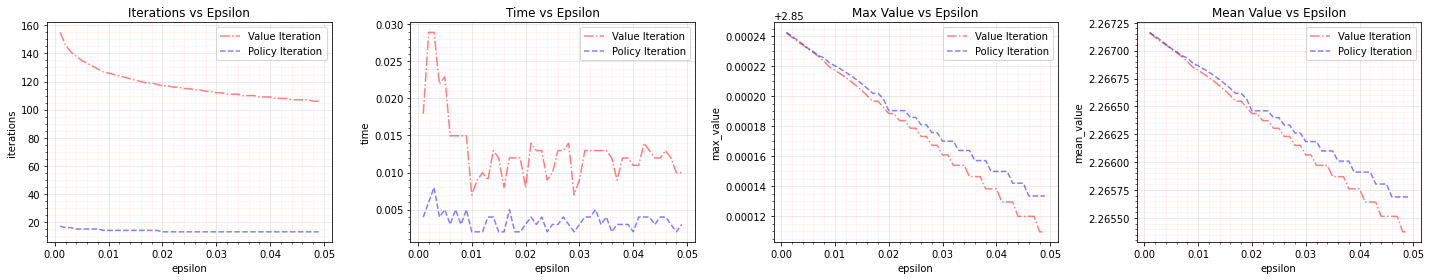

In [31]:
plot_epsilon_analysis(fl_df_epsilon_vi, fl_df_epsilon_pi)

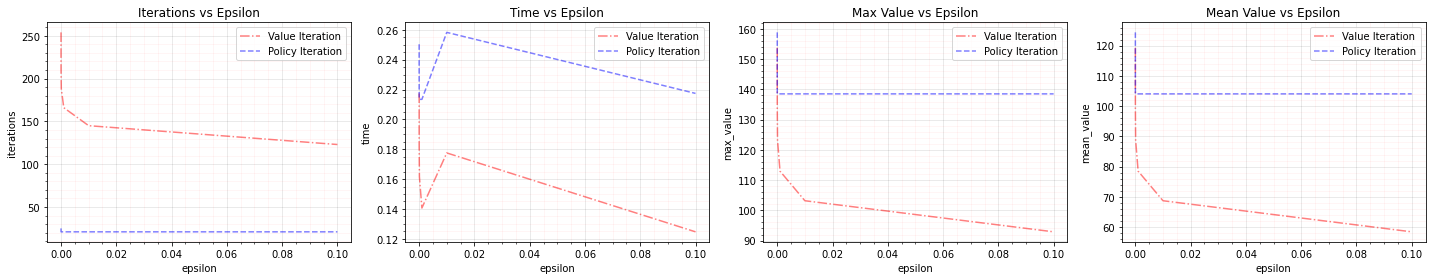

In [32]:
plot_epsilon_analysis(fm_df_epsilon_vi, fm_df_epsilon_pi)

## Optimal Policy

In [33]:
fl_vi_value_arr, fl_vi_policy_viz, fl_pi_value_arr, fl_pi_policy_viz = optimal_policy(fl_df_epsilon_vi,fl_df_epsilon_pi,fl_size,0.011,'frozen-lake')

(1, 9)
(1, 9)
(1, 64)
(1, 64)


In [34]:
fm_vi_value_arr, fm_vi_policy_viz, fm_pi_value_arr, fm_pi_policy_viz = optimal_policy(fm_df_epsilon_vi,fm_df_epsilon_pi,fm_size,0.0001,'forest')

(1, 9)
(1, 9)
(1, 1000)
(1, 1000)


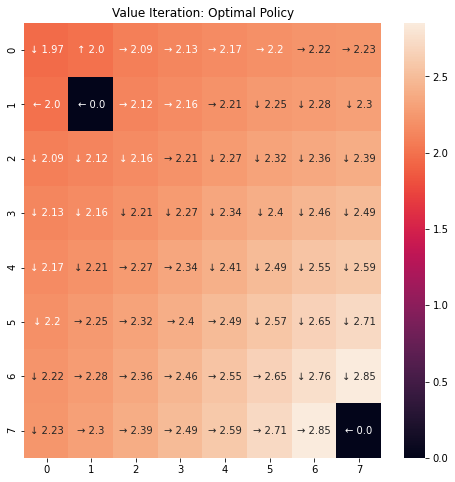

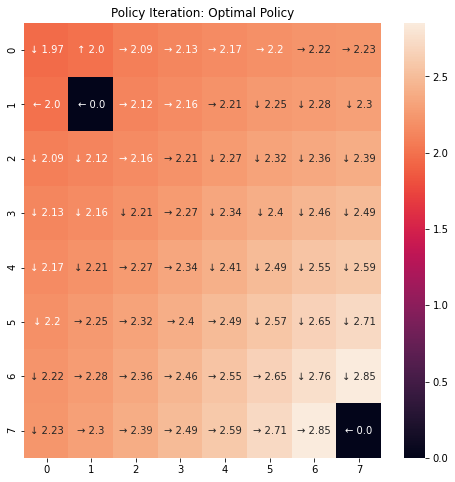

In [35]:
plot_optimnal_policy(fl_vi_value_arr, fl_vi_policy_viz, fl_pi_value_arr, fl_pi_policy_viz,fl_size,'frozen-lake')

In [36]:
plot_optimnal_policy(fm_vi_value_arr, fm_vi_policy_viz, fm_pi_value_arr, fm_pi_policy_viz,fm_size,'forest')

Value Iteration: Optimal Policy
 W 87.98 | C 88.5 | C 88.5 | C 88.5 | C 88.5 | C 88.5 | C 88.5 | C 88.5 | C 88.5 | C 88.5 | C 88.5 | C 88.5 | C 88.5 | C 88.5 | C 88.5 | C 88.5 | C 88.5 | C 88.5 | C 88.5 | C 88.5 | C 88.5 | C 88.5 | C 88.5 | C 88.5 | C 88.5 | C 88.5 | C 88.5 | C 88.5 | C 88.5 | C 88.5 | C 88.5 | C 88.5 | C 88.5 | C 88.5 | C 88.5 | C 88.5 | C 88.5 | C 88.5 | C 88.5 | C 88.5 | C 88.5 | C 88.5 | C 88.5 | C 88.5 | C 88.5 | C 88.5 | C 88.5 | C 88.5 | C 88.5 | C 88.5 | C 88.5 | C 88.5 | C 88.5 | C 88.5 | C 88.5 | C 88.5 | C 88.5 | C 88.5 | C 88.5 | C 88.5 | C 88.5 | C 88.5 | C 88.5 | C 88.5 | C 88.5 | C 88.5 | C 88.5 | C 88.5 | C 88.5 | C 88.5 | C 88.5 | C 88.5 | C 88.5 | C 88.5 | C 88.5 | C 88.5 | C 88.5 | C 88.5 | C 88.5 | C 88.5 | C 88.5 | C 88.5 | C 88.5 | C 88.5 | C 88.5 | C 88.5 | C 88.5 | C 88.5 | C 88.5 | C 88.5 | C 88.5 | C 88.5 | C 88.5 | C 88.5 | C 88.5 | C 88.5 | C 88.5 | C 88.5 | C 88.5 | C 88.5 | C 88.5 | C 88.5 | C 88.5 | C 88.5 | C 88.5 | C 88.5 | C 88.5 | C 8

## Size Analysis

In [37]:
fl_gridsizes = range(4, 50, 1)
fl_df_size_vi, fl_df_size_pi = size_analysis('frozen-lake',fl_gridsizes,size_gamma=0.99)

In [38]:
fm_sizes = range(4, 1000, 1)
fm_df_size_vi, fm_df_size_pi = size_analysis('forest',fm_sizes,size_gamma=0.99)

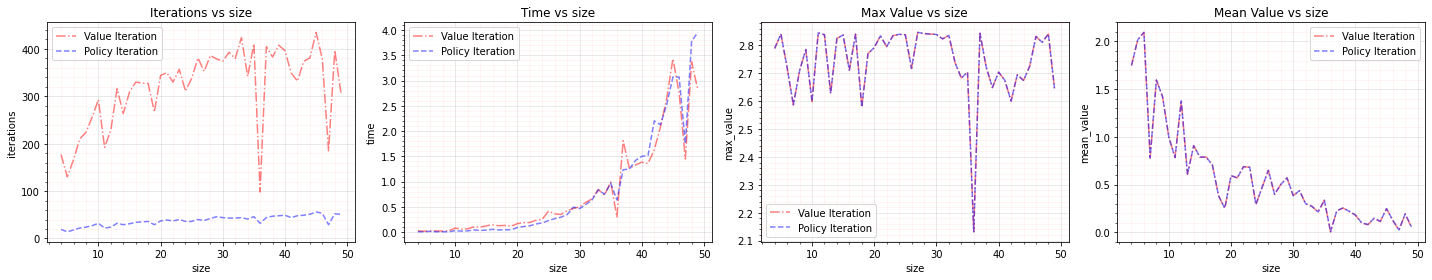

In [39]:
plot_size_analysis(fl_df_size_vi, fl_df_size_pi)

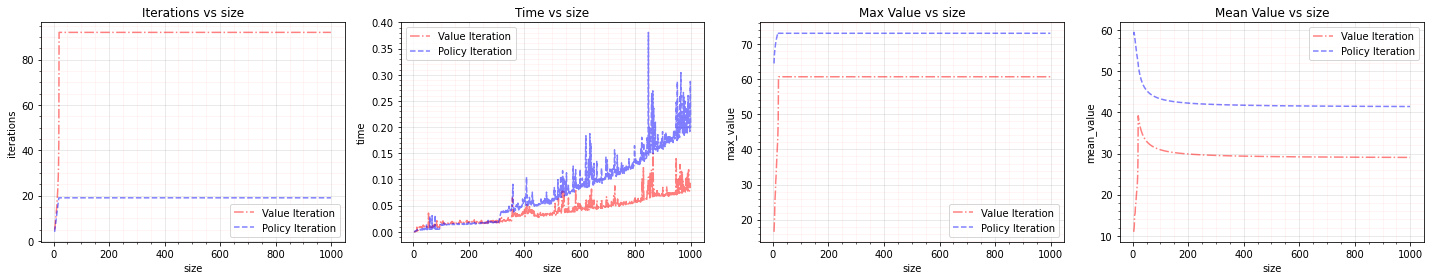

In [40]:
plot_size_analysis(fm_df_size_vi, fm_df_size_pi)

# Q Learning

## N-Iter Analysis

In [45]:
fl_ql_gamma = 0.99
fl_ql_epsilon = 0.9
# fl_ql_n_iters = [10000, 50000, 100000, 500000, 1000000]
fl_ql_n_iters = np.arange(1000,100100,1000)
# fl_ql_n_iters = np.arange(100,201,100)
fl_df_n_iter_ql, fl_df_n_iter_run_stat = ql_n_iter_analysis(fl_prob_transitions, fl_rewards,fl_size,fl_ql_gamma,fl_ql_epsilon,fl_ql_n_iters)

In [46]:
fm_ql_gamma = 0.99
fm_ql_epsilon = 0.9
# fm_ql_n_iters = [10000,50000,100000,500000,1000000]
fm_ql_n_iters = np.arange(1000,100100,1000)
fm_df_n_iter_ql, fm_df_n_iter_run_stat = ql_n_iter_analysis(fm_prob_transitions, fm_rewards,fm_size,fm_ql_gamma,fm_ql_epsilon,fm_ql_n_iters)

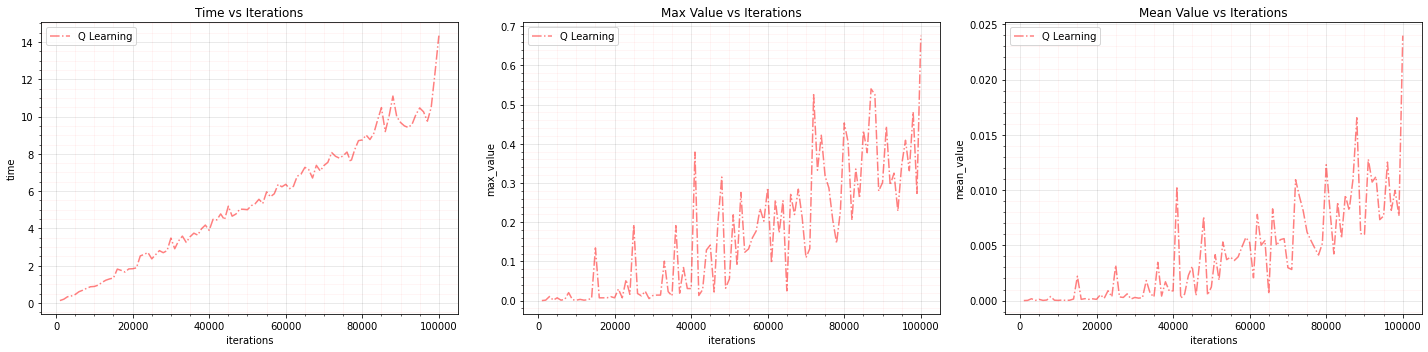

In [47]:
plot_ql_n_iter_analysis(fl_df_n_iter_ql,fl_df_n_iter_run_stat)

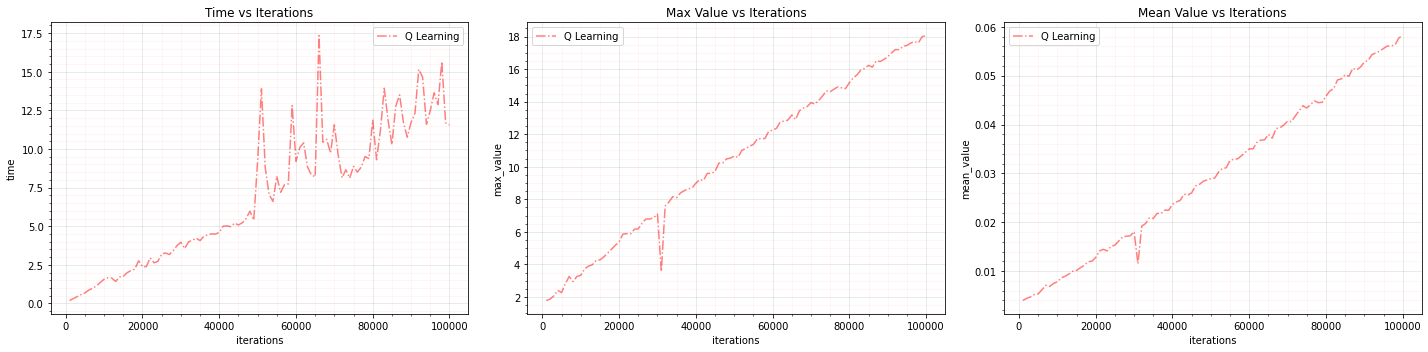

In [48]:
plot_ql_n_iter_analysis(fm_df_n_iter_ql,fm_df_n_iter_run_stat)

In [69]:
fl_df_n_iter_ql[fl_df_n_iter_ql['iterations'] == 10000]

,iter_type,size,iterations,time,max_value,mean_value,q_matrix,policy,value
9,QL,8,10000,0.889622,0.001,0.000016,"[[0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0], [...","(0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [70]:
def optimal_policy_ql(optimal_df_ql,optimal_size,iterations,env_type):
    optimal_ql = optimal_df_ql[optimal_df_ql['iterations'] == iterations]
    
    print(optimal_ql.shape)
    print(np.array(list(optimal_ql['policy'])).shape)
    
    if env_type == 'frozen-lake':
        ql_policy_arr = np.array(list(optimal_ql['policy'])).reshape(optimal_size,optimal_size).astype(str)
        ql_value_arr = np.round(np.array(list(optimal_ql['value'])).reshape(optimal_size,optimal_size),2)
        
        
        ql_policy_arr[ql_policy_arr=='0'] = '←'
        ql_policy_arr[ql_policy_arr=='1'] = '↓'
        ql_policy_arr[ql_policy_arr=='2'] = '→'
        ql_policy_arr[ql_policy_arr=='3'] = '↑'
        
        ql_policy_viz = (np.asarray([a+" "+str(v) for a, v in zip(ql_policy_arr.flatten(), ql_value_arr.flatten())])).reshape(optimal_size,optimal_size)
        
    elif env_type == 'forest':
        
        ql_policy_arr = np.array(list(optimal_ql['policy'])).reshape(optimal_size).astype(str)
        ql_value_arr = np.round(np.array(list(optimal_ql['value'])).reshape(optimal_size),2)
        
        ql_policy_arr[ql_policy_arr=='0'] = 'W'
        ql_policy_arr[ql_policy_arr=='1'] = 'C'
        
        ql_policy_viz = (np.asarray([a+" "+str(v) for a, v in zip(ql_policy_arr.flatten(), ql_value_arr.flatten())])).reshape(optimal_size)
    return ql_value_arr, ql_policy_viz

In [84]:
def plot_optimnal_policy_ql(plot_ql_value_arr, plot_ql_policy_viz,plot_size,env_type):
    
    if env_type == 'frozen-lake':
        plt.figure(figsize=(plot_size,plot_size))
        plt.title("Q Learning: Optimal Policy")
        sns.heatmap(plot_ql_value_arr, annot=plot_ql_policy_viz, fmt="")

    elif env_type == 'forest':
        print("Q Learining: Optimal Policy")
        line=""
        for val in plot_ql_policy_viz:
            line += (" {} |".format(val))
        print(line)

In [85]:
fl_ql_value_arr, fl_ql_policy_viz = optimal_policy_ql(fl_df_n_iter_ql,fl_size,100000,'frozen-lake')

(1, 9)
(1, 64)


In [86]:
fm_ql_value_arr, fm_ql_policy_viz = optimal_policy_ql(fm_df_n_iter_ql,fm_size,100000,'forest')

(1, 9)
(1, 1000)


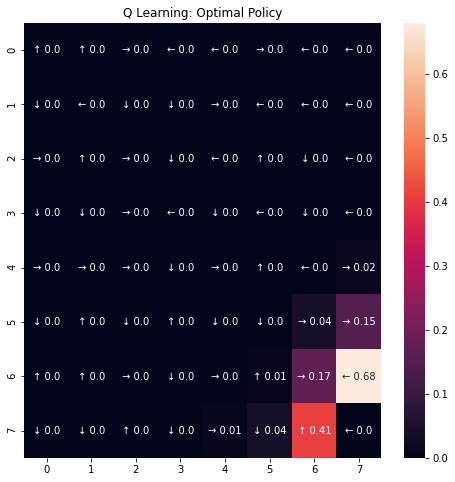

In [87]:
plot_optimnal_policy_ql(fl_ql_value_arr, fl_ql_policy_viz,fl_size,'frozen-lake')

In [88]:
plot_optimnal_policy_ql(fm_ql_value_arr, fm_ql_policy_viz,fm_size,'forest')


Q Learining: Optimal Policy
 W 17.55 | C 18.06 | C 11.17 | C 1.11 | W 0.0 | W 0.0 | C 0.06 | W 0.0 | W 0.01 | W 0.0 | W 0.0 | W 0.0 | W 0.01 | W 0.01 | C 0.08 | W 0.0 | W 0.01 | W 0.0 | W 0.01 | C 0.03 | W 0.0 | W 0.0 | W 0.0 | W 0.01 | W 0.0 | W 0.01 | W 0.01 | W 0.01 | W 0.03 | W 0.0 | W 0.0 | W 0.02 | W 0.0 | W 0.01 | W 0.01 | W 0.01 | W 0.0 | W 0.02 | W 0.01 | W 0.0 | W 0.0 | W 0.0 | W 0.0 | W 0.02 | W 0.01 | W 0.0 | C 0.01 | W 0.0 | W 0.0 | C 0.07 | W 0.0 | W 0.0 | W 0.0 | C 0.04 | W 0.0 | W 0.0 | W 0.0 | W 0.0 | C 0.01 | C 0.05 | C 0.01 | W 0.0 | W 0.0 | W 0.0 | W 0.0 | W 0.0 | W 0.0 | C 0.03 | W 0.0 | W 0.0 | W 0.0 | W 0.0 | W 0.0 | W 0.0 | W 0.0 | W 0.0 | W 0.0 | W 0.0 | C 0.09 | C 0.0 | W 0.0 | W 0.0 | C 0.04 | W 0.0 | W 0.0 | W 0.0 | C 0.02 | W 0.0 | W 0.0 | W 0.0 | C 0.04 | W 0.0 | W 0.0 | W 0.0 | W 0.0 | C 0.03 | W 0.0 | W 0.0 | C 0.0 | W 0.0 | W 0.0 | W 0.0 | W 0.0 | C 0.05 | W 0.0 | W 0.0 | W 0.0 | W 0.0 | W 0.01 | W 0.01 | C 0.05 | C 0.03 | W 0.0 | W 0.0 | W 0.02 | W 0.0